In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
# read the files
results_data_file = pd.read_csv(r"..\cleaned_data\f1db-races-race-results-CLEANED.csv")
quals_data_file = pd.read_csv(r"..\cleaned_data\f1db-races-qualifying-results-CLEANED.csv")

# create list of unique race ids
race_id_list = results_data_file['raceId'].unique()

In [32]:
# Compute the difference between Fastest Qualifying Time grid and the Starting Grid

time_data = quals_data_file[quals_data_file['q1Millis']>0] # get the races which have the qualifying data we need
new_race_id_list = time_data['raceId'].unique()

qs_difference = [] # here 'qs difference' stands for 'Qualifying-Starting difference' 

for race_id in new_race_id_list:
    qual_data = quals_data_file[quals_data_file['raceId'] == race_id]
    driver_number_data = list(qual_data['driverNumber'])
    q1_time_data = list(qual_data['q1Millis'])
    q2_time_data = list(qual_data['q2Millis'])
    q3_time_data = list(qual_data['q3Millis'])

    min_qual_time_data = {}
    min_qual_time_list = []
    num_of_drivers = len(q1_time_data)
    for x in range(num_of_drivers):
        min_qual_time = min(q1_time_data[x],q2_time_data[x],q3_time_data[x])
        min_qual_time_data[x] = min_qual_time
        min_qual_time_list.append(min_qual_time)

    fastest_qual_time_positions = sorted(min_qual_time_list)
    position_difference = 0

    for y in range(num_of_drivers):
        if fastest_qual_time_positions[y] != min_qual_time_data[y]:
            position_difference += 1
    
    qs_difference.append(position_difference)

print(max(qs_difference))

23


In [34]:
# create clusters based off of the time gap 1 second

def new_time_open_ball(time, time_list):        # Get sets of open balls with radius 1 second and basepoint each time
    new_open_ball = {time}

    for other_time in time_list:
        if abs(time - other_time) < 1000: 
            new_open_ball.add(other_time)

    return new_open_ball

def get_clusters(set_of_times):                 # Generate all the clusters of times within 1 second of each other       
    time_clusters = []

    for set_1 in set_of_times:
        if len(time_clusters) > 0: 
            cluster_union = set.union(*time_clusters)
        else: 
            cluster_union = set()

        if set_1 & cluster_union: continue

        cluster = set_1
        for set_2 in set_of_times:
            if cluster & set_2:
                cluster = cluster | set_2
        time_clusters.append(cluster)

    return time_clusters

def sqmean_drivers_per_cluster(clusters_of_time, num_of_drivers):     # Gets squared mean number of drivers per cluster
    squared_mean = 0

    for cluster in clusters_of_time:
        num_of_drivers_in_cluster = len(cluster)
        squared_mean += num_of_drivers_in_cluster**2
    
    squared_mean = squared_mean / num_of_drivers

    return squared_mean

def further_sqmean_drivers_per_cluster(clusters_of_time, num_of_drivers):
    if num_of_drivers > 1:
        further_squared_mean = sqmean_drivers_per_cluster(clusters_of_time, num_of_drivers) / (num_of_drivers - 1)
    else:
        further_squared_mean = 0

    return further_squared_mean

cluster_sqmean = []
further_cluster_sqmean = []
qs_cluster_sqmean = []
qs_further_cluster_sqmean = []

for race_id in race_id_list:
    race_data = results_data_file[results_data_file['raceId'] == race_id]
    necessary_data = race_data[race_data['timeMillis']>0]
    time_data = list(necessary_data['timeMillis'])
    time_sets = []
    num_drivers = len(time_data)

    for time in time_data:
        time_sets.append(new_time_open_ball(time, time_data))

    race_time_clusters = get_clusters(time_sets)
    cluster_sqmean.append(sqmean_drivers_per_cluster(race_time_clusters, num_drivers))
    further_cluster_sqmean.append(further_sqmean_drivers_per_cluster(race_time_clusters, num_drivers))

for race_id in new_race_id_list:
    race_data = results_data_file[results_data_file['raceId'] == race_id]
    necessary_data = race_data[race_data['timeMillis']>0]
    time_data = list(necessary_data['timeMillis'])
    time_sets = []
    num_drivers = len(time_data)

    for time in time_data:
        time_sets.append(new_time_open_ball(time, time_data))

    race_time_clusters = get_clusters(time_sets)
    qs_cluster_sqmean.append(sqmean_drivers_per_cluster(race_time_clusters, num_drivers))
    qs_further_cluster_sqmean.append(further_sqmean_drivers_per_cluster(race_time_clusters, num_drivers))

print(max(qs_cluster_sqmean))

8.266666666666667


In [23]:
cluster_sqmean_data = pd.DataFrame({
    "cluster squared mean": cluster_sqmean,
    "raceId": race_id_list
})

cluster_sqmean_data.to_csv("Cluster Squared Mean.csv", index=False)

In [26]:
further_cluster_sqmean_data = pd.DataFrame({
    "further cluster squared mean": further_cluster_sqmean,
    "raceId": race_id_list
})

further_cluster_sqmean_data.to_csv("Cluster Further Squared Mean.csv", index=False)

In [35]:
sqmean_qs_difference_data = pd.DataFrame({
    "cluster squared mean": qs_cluster_sqmean,
    "qualifying_starting_difference": qs_difference
})

sqmean_qs_difference_data.to_csv("QS Cluster Data.csv", index=False)

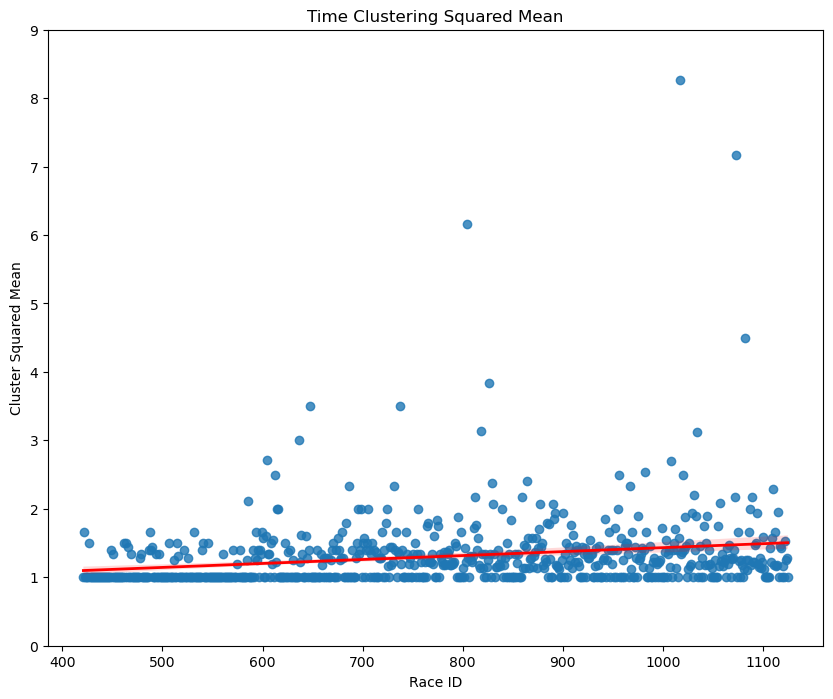

In [25]:
# Plot Cluster Squared Mean vs. Race ID

plt.rcParams["figure.figsize"] = (10,8)
sns.regplot(data = cluster_sqmean_data,
                x = "raceId",
                y = "cluster squared mean",
                line_kws= {'color':'red', "linewidth" : 2},
                order = 1)
plt.ylim(0,9)
#plt.axvline(x = 955, color = 'black')
plt.title("Time Clustering Squared Mean")
plt.xlabel("Race ID")
plt.ylabel("Cluster Squared Mean")
plt.savefig("Time Clustering Squared Mean.png")

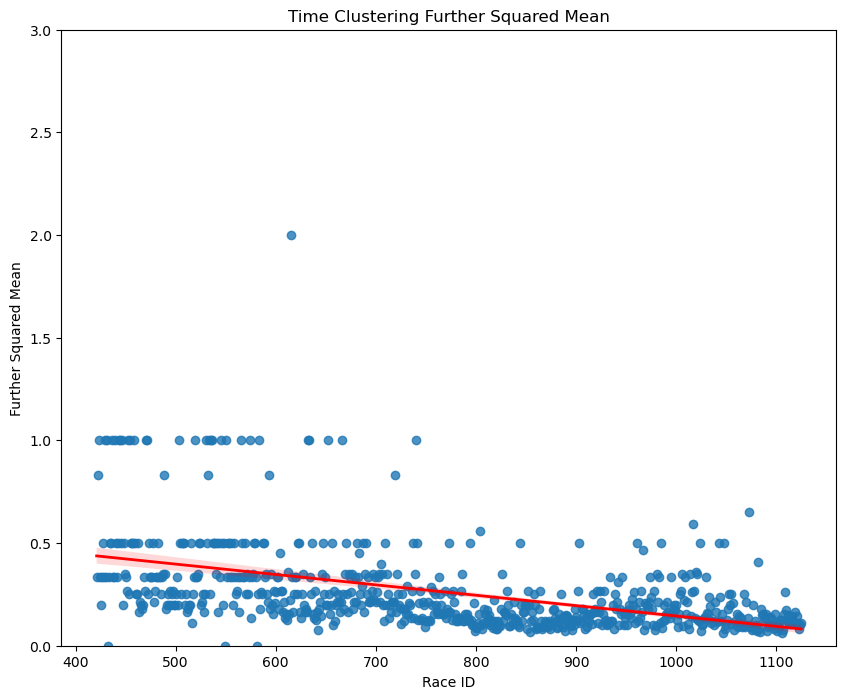

In [ ]:
# Plot Cluster Further Squared Mean vs. Race ID

plt.rcParams["figure.figsize"] = (10,8)
sns.regplot(data = further_cluster_sqmean_data,
                x = "raceId",
                y = "cluster squared mean",
                line_kws= {'color':'red', "linewidth" : 2},
                order = 1)
plt.ylim(0,9)
#plt.axvline(x = 955, color = 'black')
plt.title("Time Clustering Further Squared Mean")
plt.xlabel("Race ID")
plt.ylabel("Further Squared Mean")
plt.savefig("Time Clustering Further Squared Mean.png")

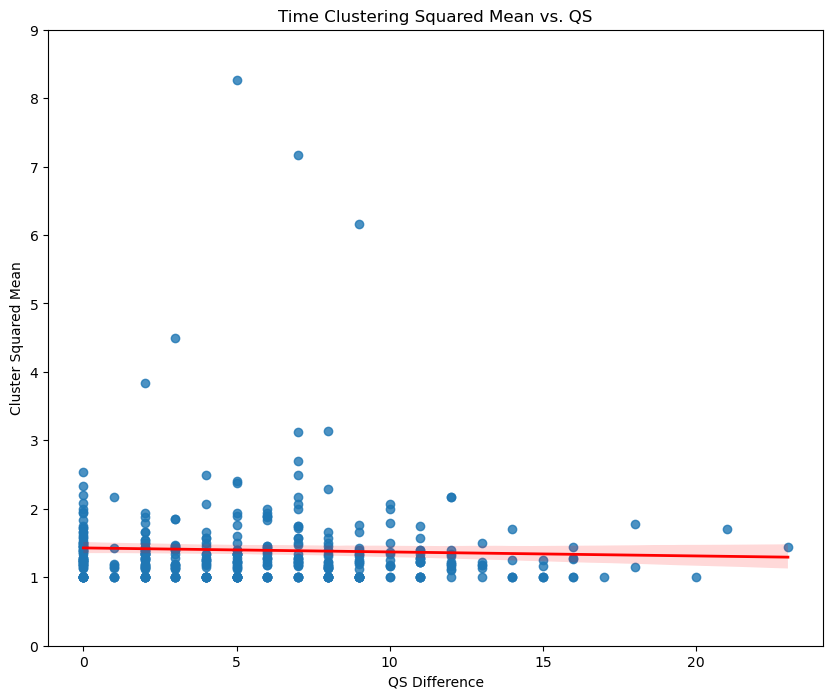

In [36]:
# Plot Cluster Squared Mean vs. QS difference

plt.rcParams["figure.figsize"] = (10,8)
sns.regplot(data = sqmean_qs_difference_data,
                x = "qualifying_starting_difference",
                y = "cluster squared mean",
                line_kws= {'color':'red', "linewidth" : 2},
                order = 1)
plt.ylim(0,9)
#plt.axvline(x = 955, color = 'black')
plt.title("Time Clustering Squared Mean vs. QS")
plt.xlabel("QS Difference")
plt.ylabel("Cluster Squared Mean")
plt.savefig("Time Clustering Squared Mean vs QS.png")